(interrupted_time_series)=
# Interrupted time series analysis

:::{post} Oct, 2022
:tags: counterfactuals, causal inference, time series, forecasting, causal impact, quasi experiments
:category: intermediate
:author: Benjamin T. Vincent
:::

This notebook focuses on how to conduct a simple Bayesian [interrupted time series analysis](https://en.wikipedia.org/wiki/Interrupted_time_series). This is useful in [quasi-experimental settings](https://en.wikipedia.org/wiki/Quasi-experiment) where an intervention was applied to all treatment units. 

For example, if a change to a website was made and you want to know the causal impact of the website change then _if_ this change was applied selectively and randomly to a test group of website users, then you may be able to make causal claims using the [A/B testing approach](https://en.wikipedia.org/wiki/A/B_testing).

However, if the website change was rolled out to _all_ users of the website then you do not have a control group. In this case you do not have a direct measurement of the counterfactual, what _would have happened if_ the website change was not made. In this case, if you have data over a 'good' number of time points, then you may be able to make use of the interrupted time series approach.

Interested readers are directed to the excellent textbook [The Effect](https://theeffectbook.net/) {cite:p}`huntington2021effect`. Chapter 17 covers 'event studies' which the author prefers to the interrupted time series terminology.

## Causal DAG

A simple causal DAG for the interrupted time series is given below, but see {cite:p}`huntington2021effect` for a more general DAG. In short it says:

* The outcome is causally influenced by time (e.g. other factors that change over time) and by the treatment.
* The treatment is causally influenced by time.

![](DAG_interrupted_time_series.png)

Intuitively, we could describe the logic of the approach as:
* We know that the outcome varies over time.
* If we build a model of how the outcome varies over time _before_ the treatment, then we can predit the counterfactual of what we would expect to happen _if_ the treatment had not occurred.
* We can compare this counterfactual with the observations from the time of the intervention onwards. If there is a meaningful discrepancy then we can attribute this as a causal impact of the intervention. 

This is reasonable if we have ruled out other plausible causes occurring at the same point in time as (or after) the intervention. This becomes more tricky to justify the more time has passed since the intervention because it is more likely that other relevant events maye have occurred that could provide alternative causal explanations.

If this does not make sense immediately, I recommend checking the example data figure below then revisiting this section.

In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from scipy.stats import norm

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Now let's define some helper functions

In [3]:
def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

## Generate data

The focus of this example is on making causal claims using the interrupted time series approach. Therefore we will work with some relatively simple synthetic data which only requires a very simple model.

In [4]:
treatment_time = "2017-01-01"
β0 = 0
β1 = 0.1
dates = pd.date_range(
    start=pd.to_datetime("2010-01-01"), end=pd.to_datetime("2020-01-01"), freq="M"
)
N = len(dates)


def causal_effect(df):
    return (df.index > treatment_time) * 2


df = (
    pd.DataFrame()
    .assign(time=np.arange(N), date=dates)
    .set_index("date", drop=True)
    .assign(y=lambda x: β0 + β1 * x.time + causal_effect(x) + norm(0, 0.5).rvs(N))
)
df

,time,y
date,,
2010-01-31,0,0.471863
2010-02-28,1,-0.212513
2010-03-31,2,0.842626
2010-04-30,3,0.538445
2010-05-31,4,0.562607
...,...,...
2019-08-31,115,13.587538
2019-09-30,116,14.017643
2019-10-31,117,14.004404


In [5]:
# Split into pre and post intervention dataframes
pre = df[df.index < treatment_time]
post = df[df.index >= treatment_time]

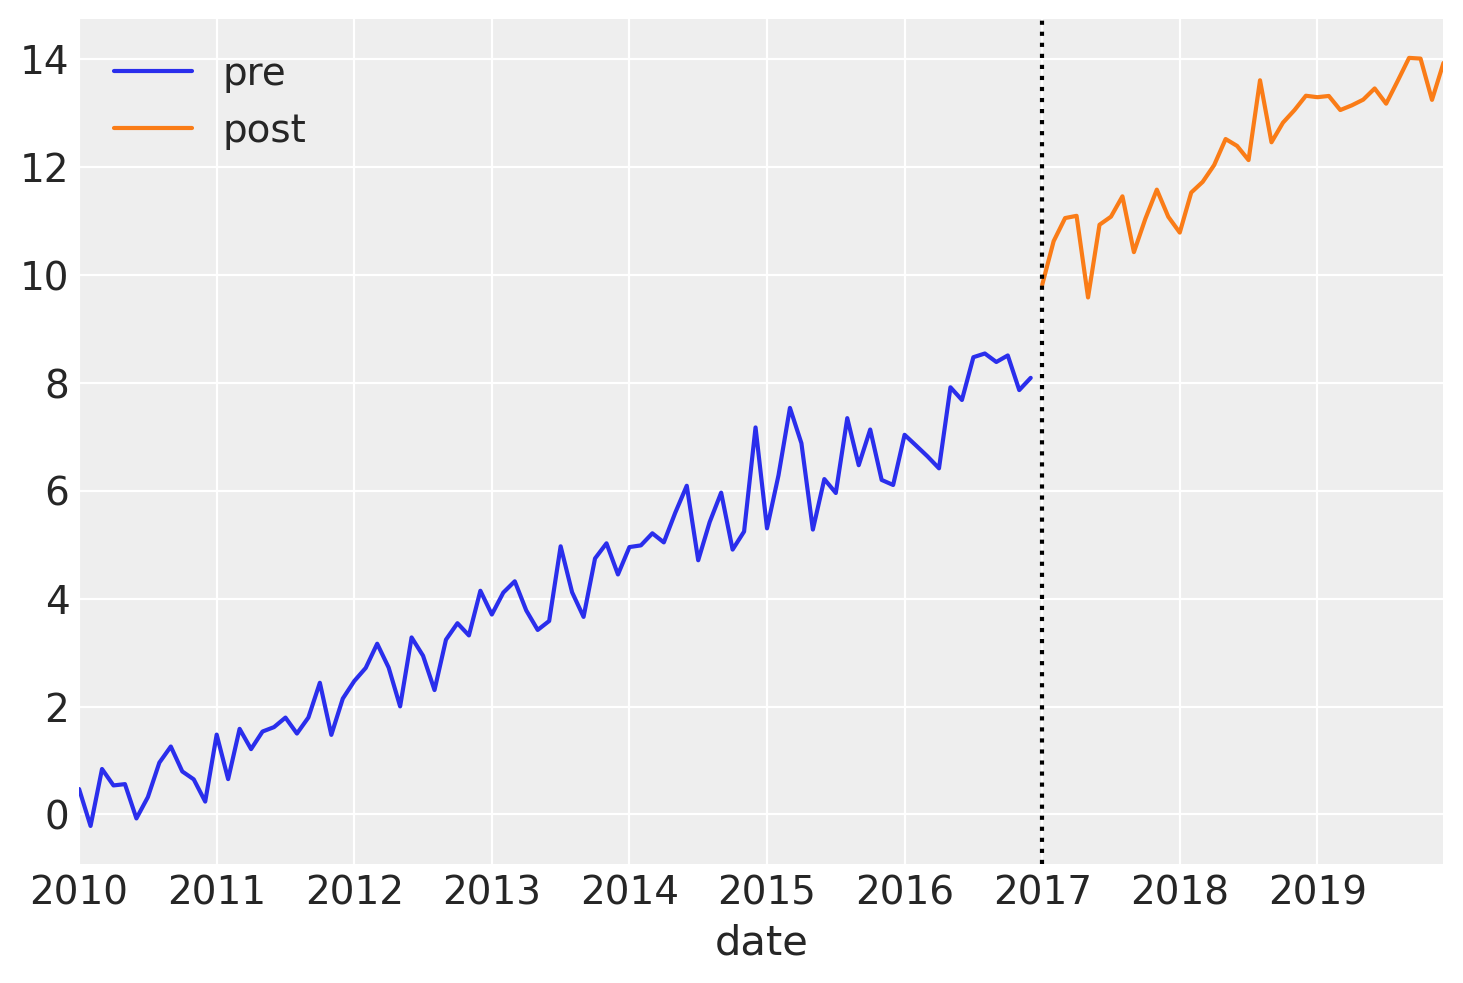

In [6]:
fig, ax = plt.subplots()
ax = pre["y"].plot(label="pre")
post["y"].plot(ax=ax, label="post")
ax.axvline(treatment_time, c="k", ls=":")
plt.legend();

In this simple dataset, we have a noisy linear trend upwards, and because this data is synthetic we know that we have a step increase in the outcome at the intervention time, and this effect is persistent over time.

## Modelling
Here we build a simple linear model. Remember that we are building a model of the pre-intervention data with the goal that it would do a reasonable job of forecasting what would have happened if the intervention had not been applied. Put another way, we are _not_ modelling any aspect of the post-intervention observations such as a change in intercept, slope or whether the effect is transient or permenent.

In [7]:
with pm.Model() as model:
    # observed predictors and outcome
    time = pm.MutableData("time", pre["time"].to_numpy(), dims="obs_id")
    # priors
    beta0 = pm.Normal("beta0", 0, 1)
    beta1 = pm.Normal("beta1", 0, 0.2)
    # the actual linear model
    mu = pm.Deterministic("mu", beta0 + (beta1 * time), dims="obs_id")
    sigma = pm.HalfNormal("sigma", 2)
    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=pre["y"].to_numpy(), dims="obs_id")

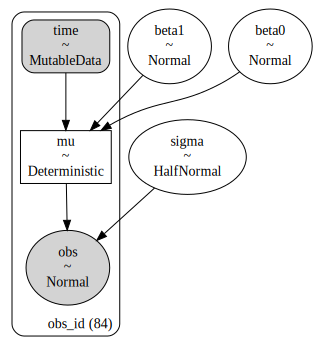

In [8]:
pm.model_to_graphviz(model)

## Prior predictive check

As part of the Bayesian workflow, we will plot our prior predictions to see what outcomes the model finds before having observed any data.

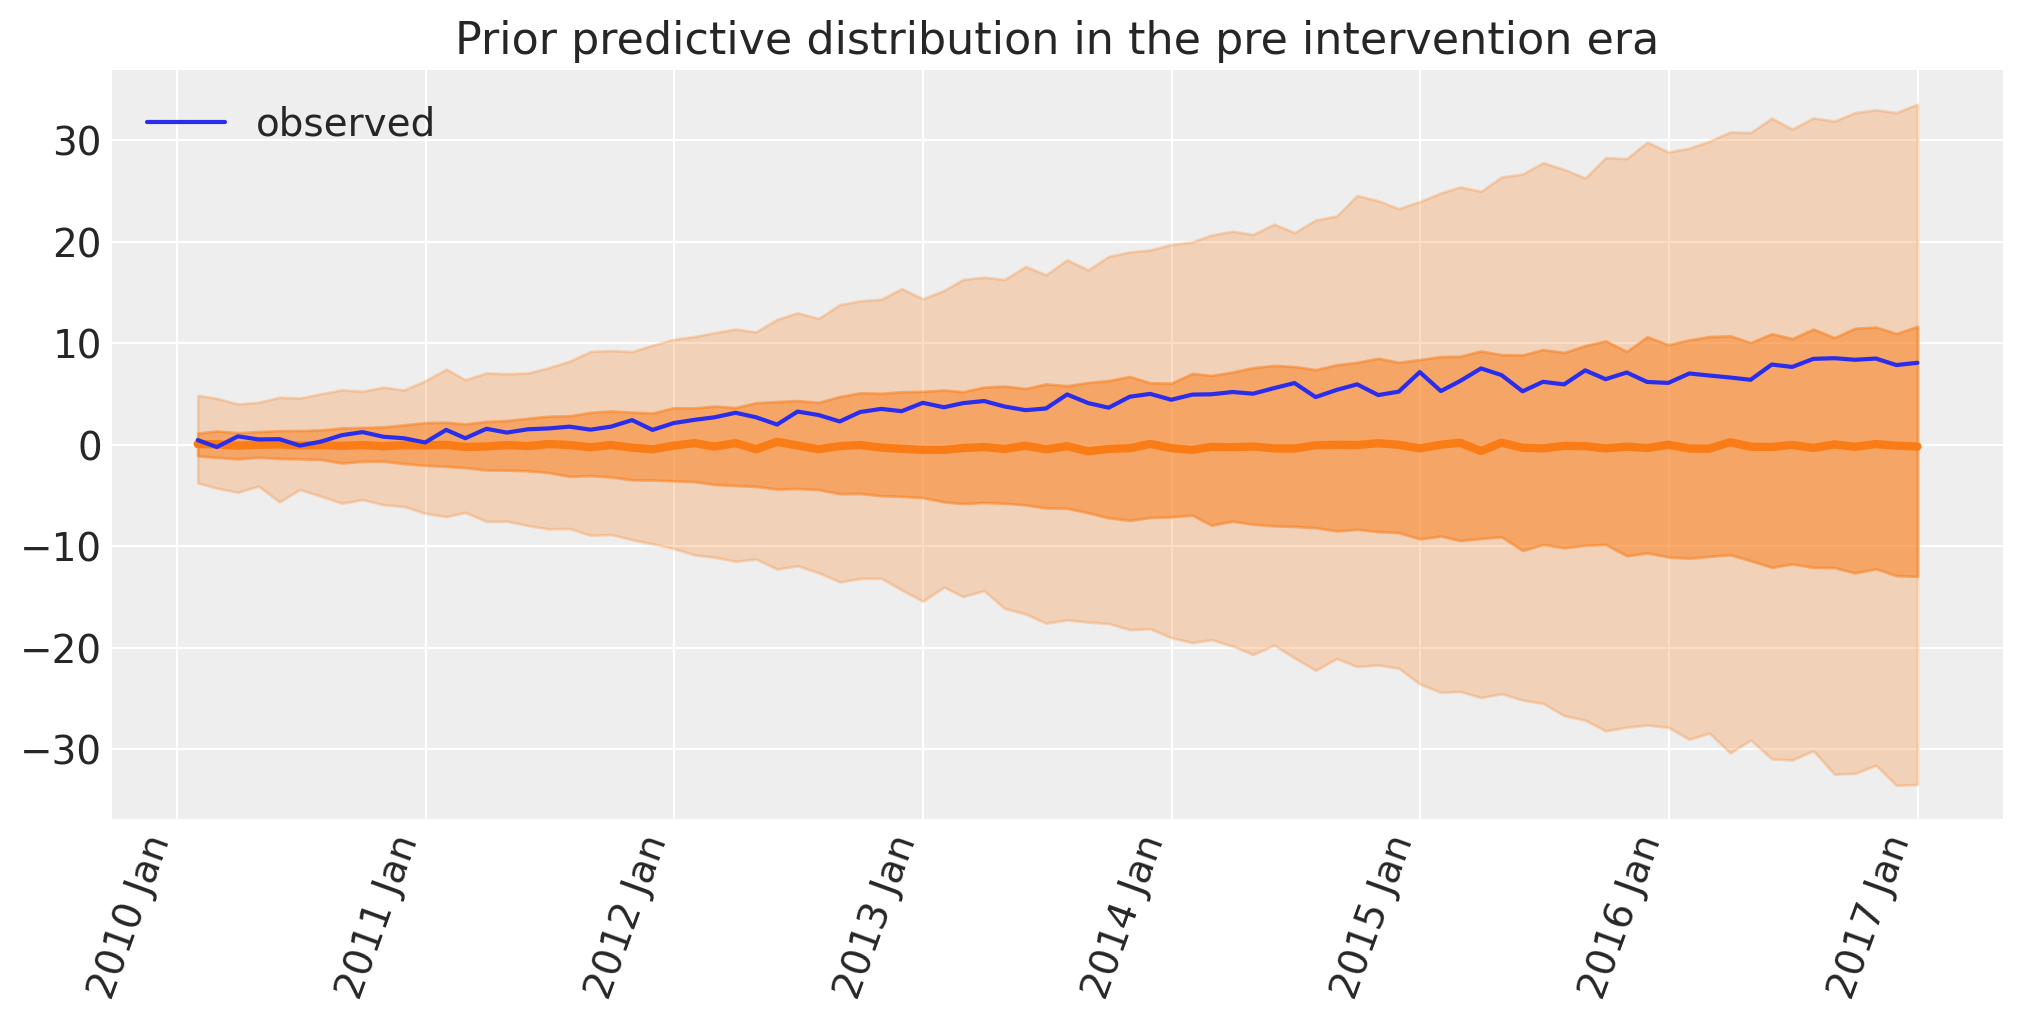

In [9]:
with model:
    idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(pre.index, pre["y"], label="observed")
ax.set(title="Prior predictive distribution in the pre intervention era")
plt.legend();

This seems reasonable in that the priors over the intercept and slope are broad enough to lead to predicted observations which easily contain the actual data. This means that the particular priors chosen will not unduly constrain the posterior parameter estimates.

## Inference 
Draw samples for the posterior distribution, and remember we are doing this for the pre intervention data only.

In [10]:
with model:
    idata.extend(pm.sample(random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


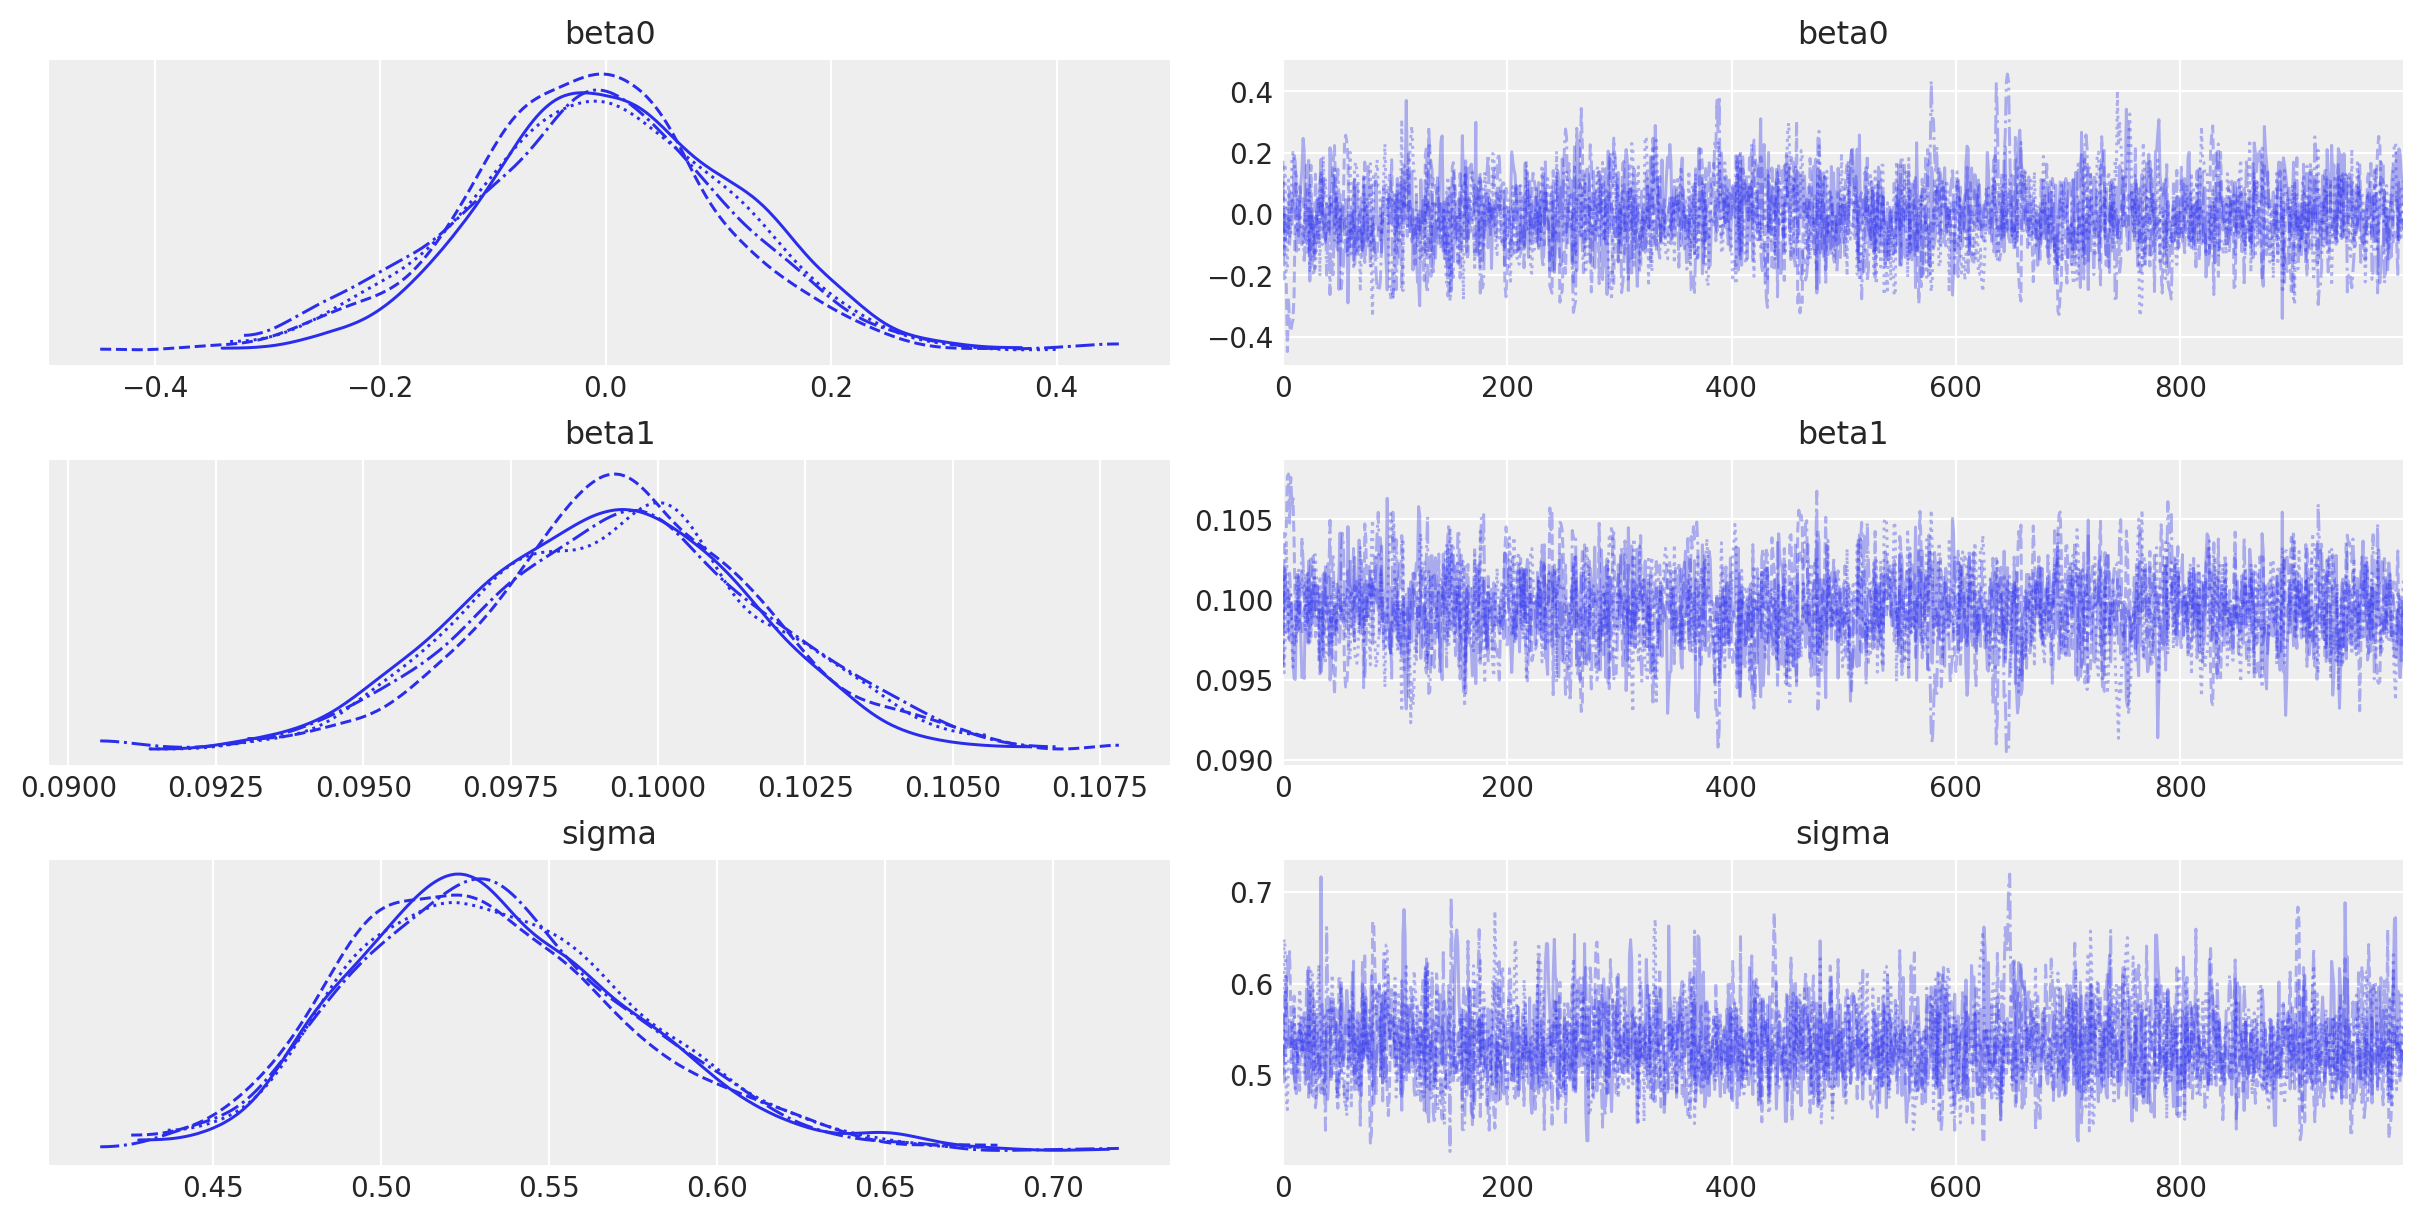

In [11]:
az.plot_trace(idata, var_names=["~mu"]);

## Posterior predictive check

Another important aspect of the Bayesian workflow is to plot the model's posterior predictions, allowing us to see how well the model can retrodict the already observed data. It is at this point that we can decide whether the model is too simple (then we'd build more complexity into the model) or if it's fine.

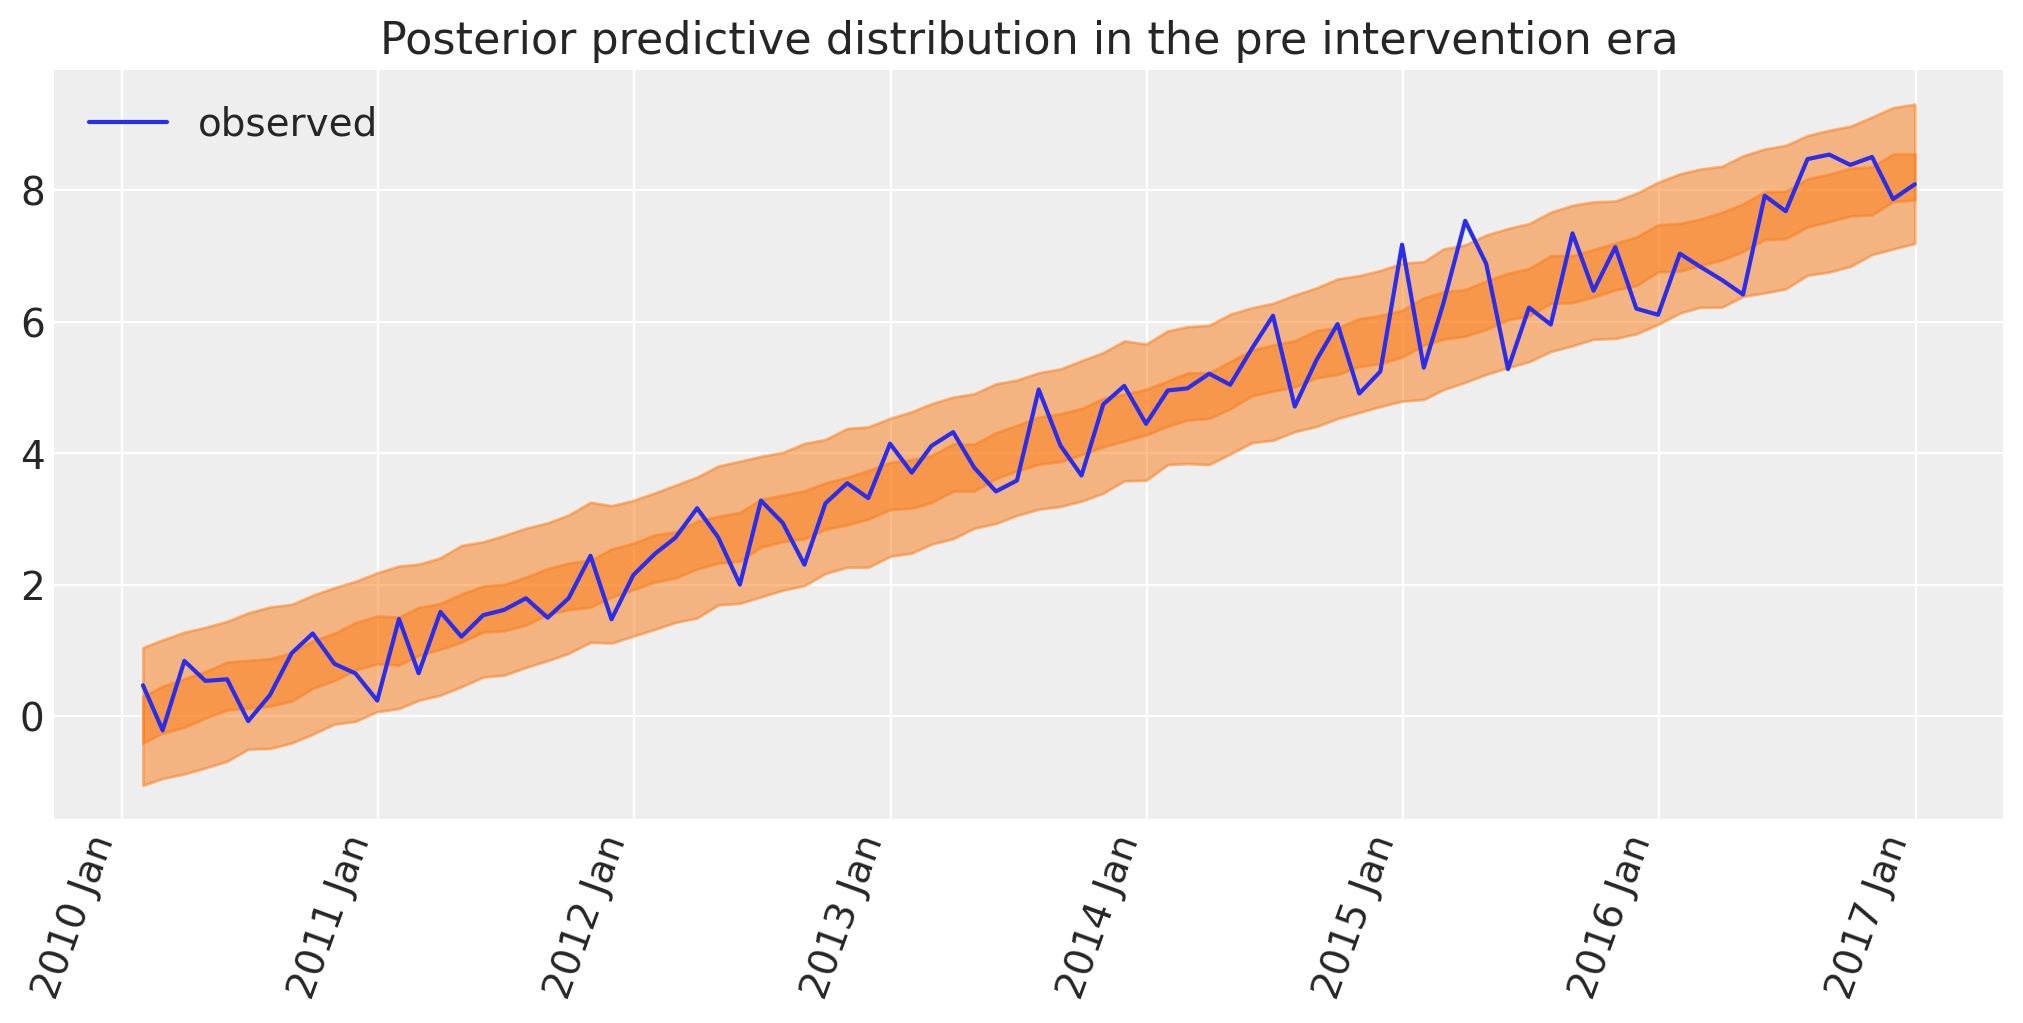

In [12]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))

fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(pre.index, pre["y"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre intervention era")
plt.legend();

The next step is not strictly necessary, but we can calculate the difference between the model retrodictions and the data to look at the errors. This can be useful to identify any unexpected inability to retrodict pre-intervention data.

In [13]:
# convert outcome into an XArray object with a labelled dimension to help in the next step
y = xr.DataArray(pre["y"].to_numpy(), dims=["obs_id"])

# do the calculation by taking the difference
excess = y - idata.posterior_predictive["obs"]

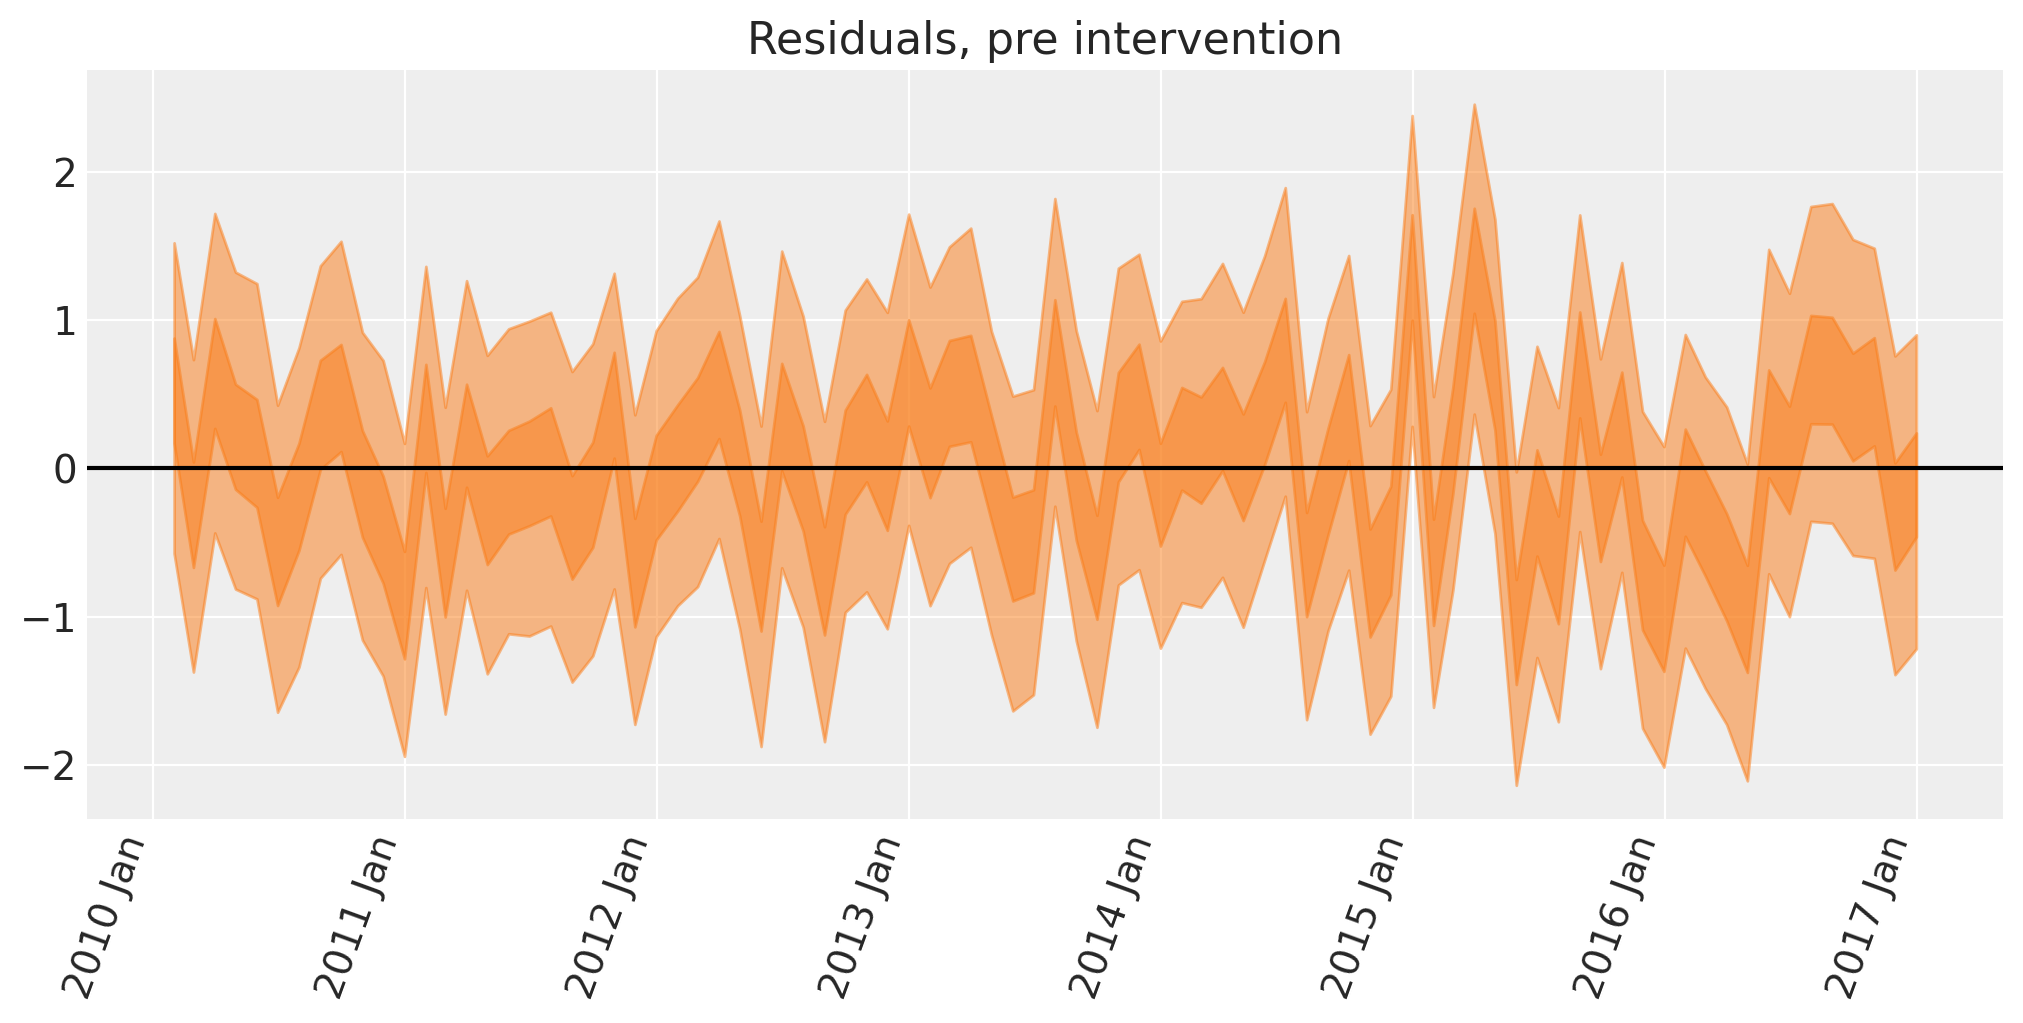

In [14]:
fig, ax = plt.subplots(figsize=figsize)
# the transpose is to keep arviz happy, ordering the dimensions as (chain, draw, time)
az.plot_hdi(pre.index, excess.transpose(..., "obs_id"), hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, excess.transpose(..., "obs_id"), hdi_prob=0.95, smooth=False)
format_x_axis(ax)
ax.axhline(y=0, color="k")
ax.set(title="Residuals, pre intervention");

## Counterfactual inference
Now we will use our model to predict the observed outcome in the 'what if?' scenario of no intervention.

So we update the model with the `time` data from the `post` intervention dataframe and run posterior predictive sampling to predict the observations we would observe in this counterfactual scenario. We could also call this 'forecasting'.

In [15]:
with model:
    pm.set_data(
        {
            "time": post["time"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=RANDOM_SEED
    )

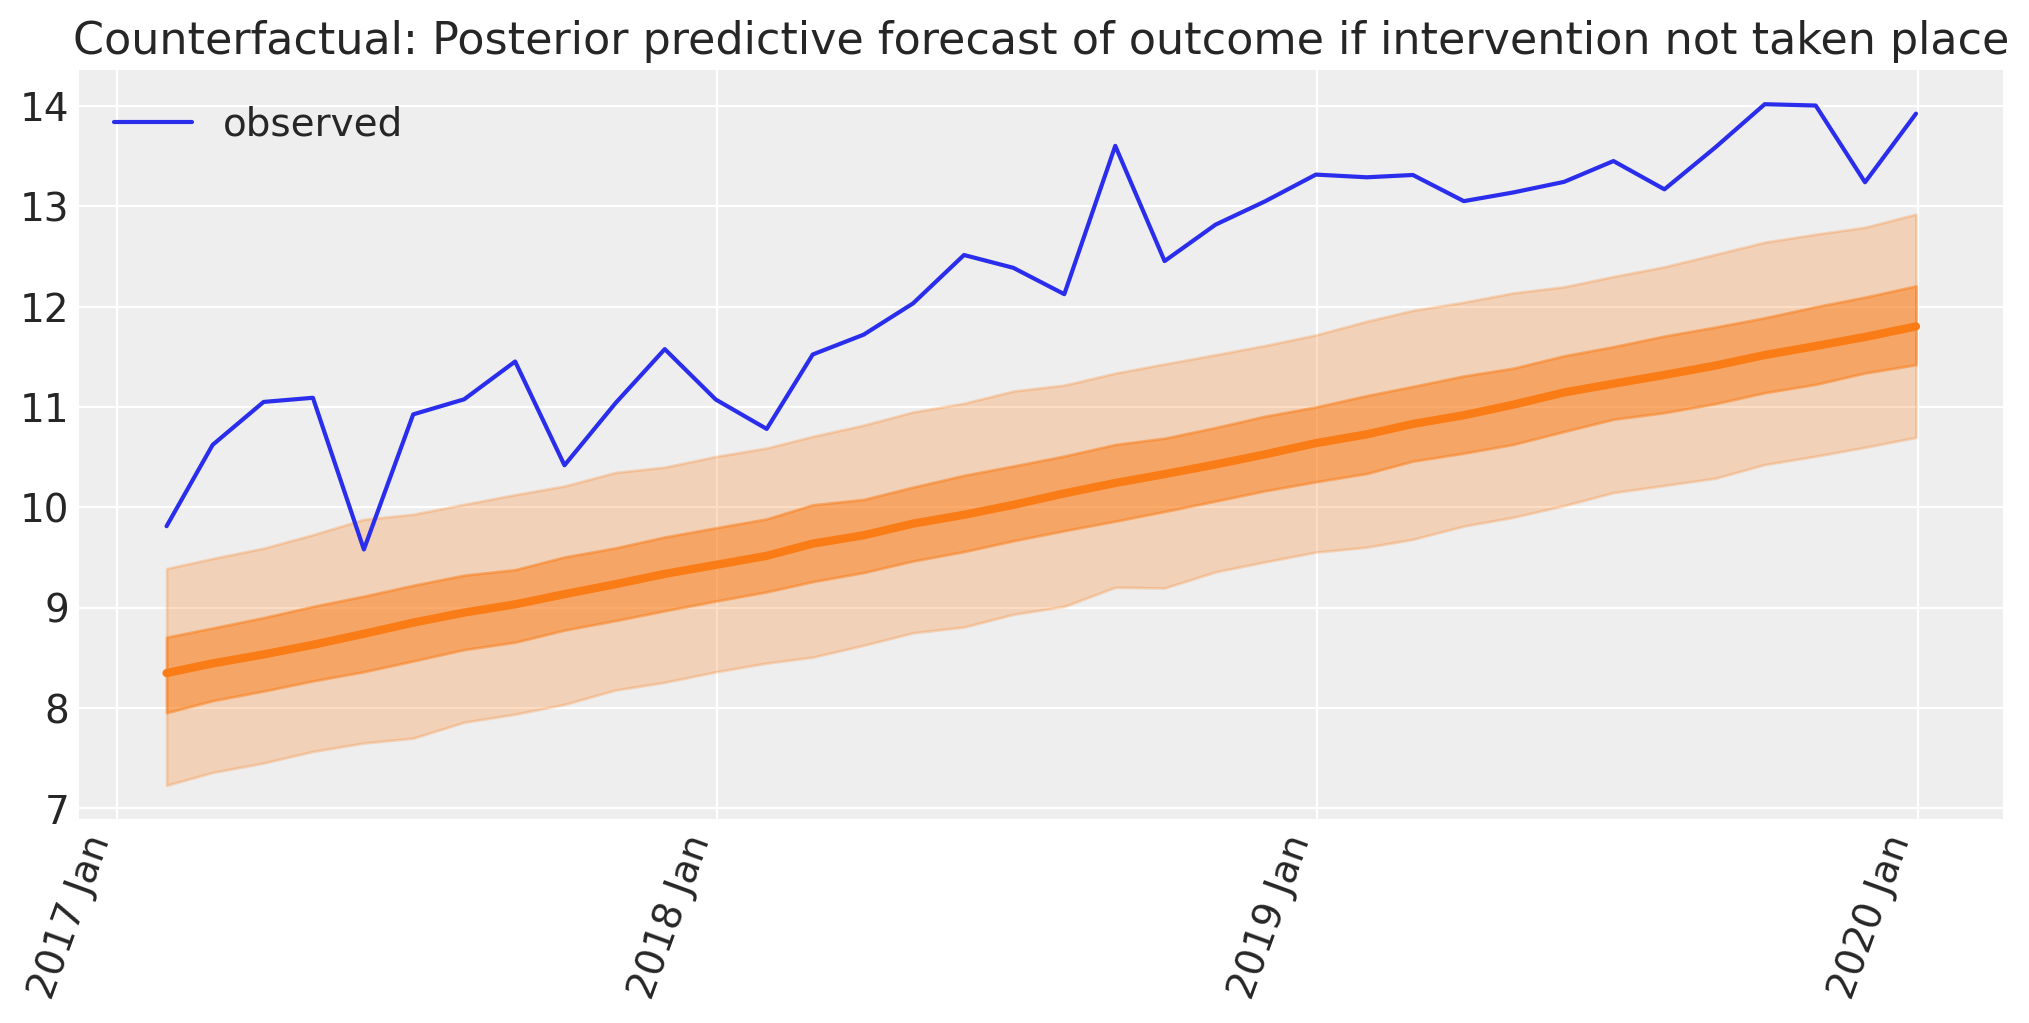

In [16]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=False)
ax.plot(post.index, post["y"], label="observed")
ax.set(
    title="Counterfactual: Posterior predictive forecast of outcome if intervention not taken place"
)
plt.legend();

We now have the ingredients needed to calculate the causal impact. This is simply the difference between the Bayesian counterfactual predictions and the observations.

## Causal impact: since the intervention

Now we'll use the predicted outcome under the counterfactual scenario and compare that to the observed outcome to come up with our counterfactual estimate.

In [17]:
# convert outcome into an XArray object with a labelled dimension to help in the next step
outcome = xr.DataArray(post["y"].to_numpy(), dims=["obs_id"])

# do the calculation by taking the difference
excess = outcome - counterfactual.posterior_predictive["obs"]

And we can easily compute the cumulative causal impact

In [18]:
# calculate the cumulative causal impact
cumsum = excess.cumsum(dim="obs_id")

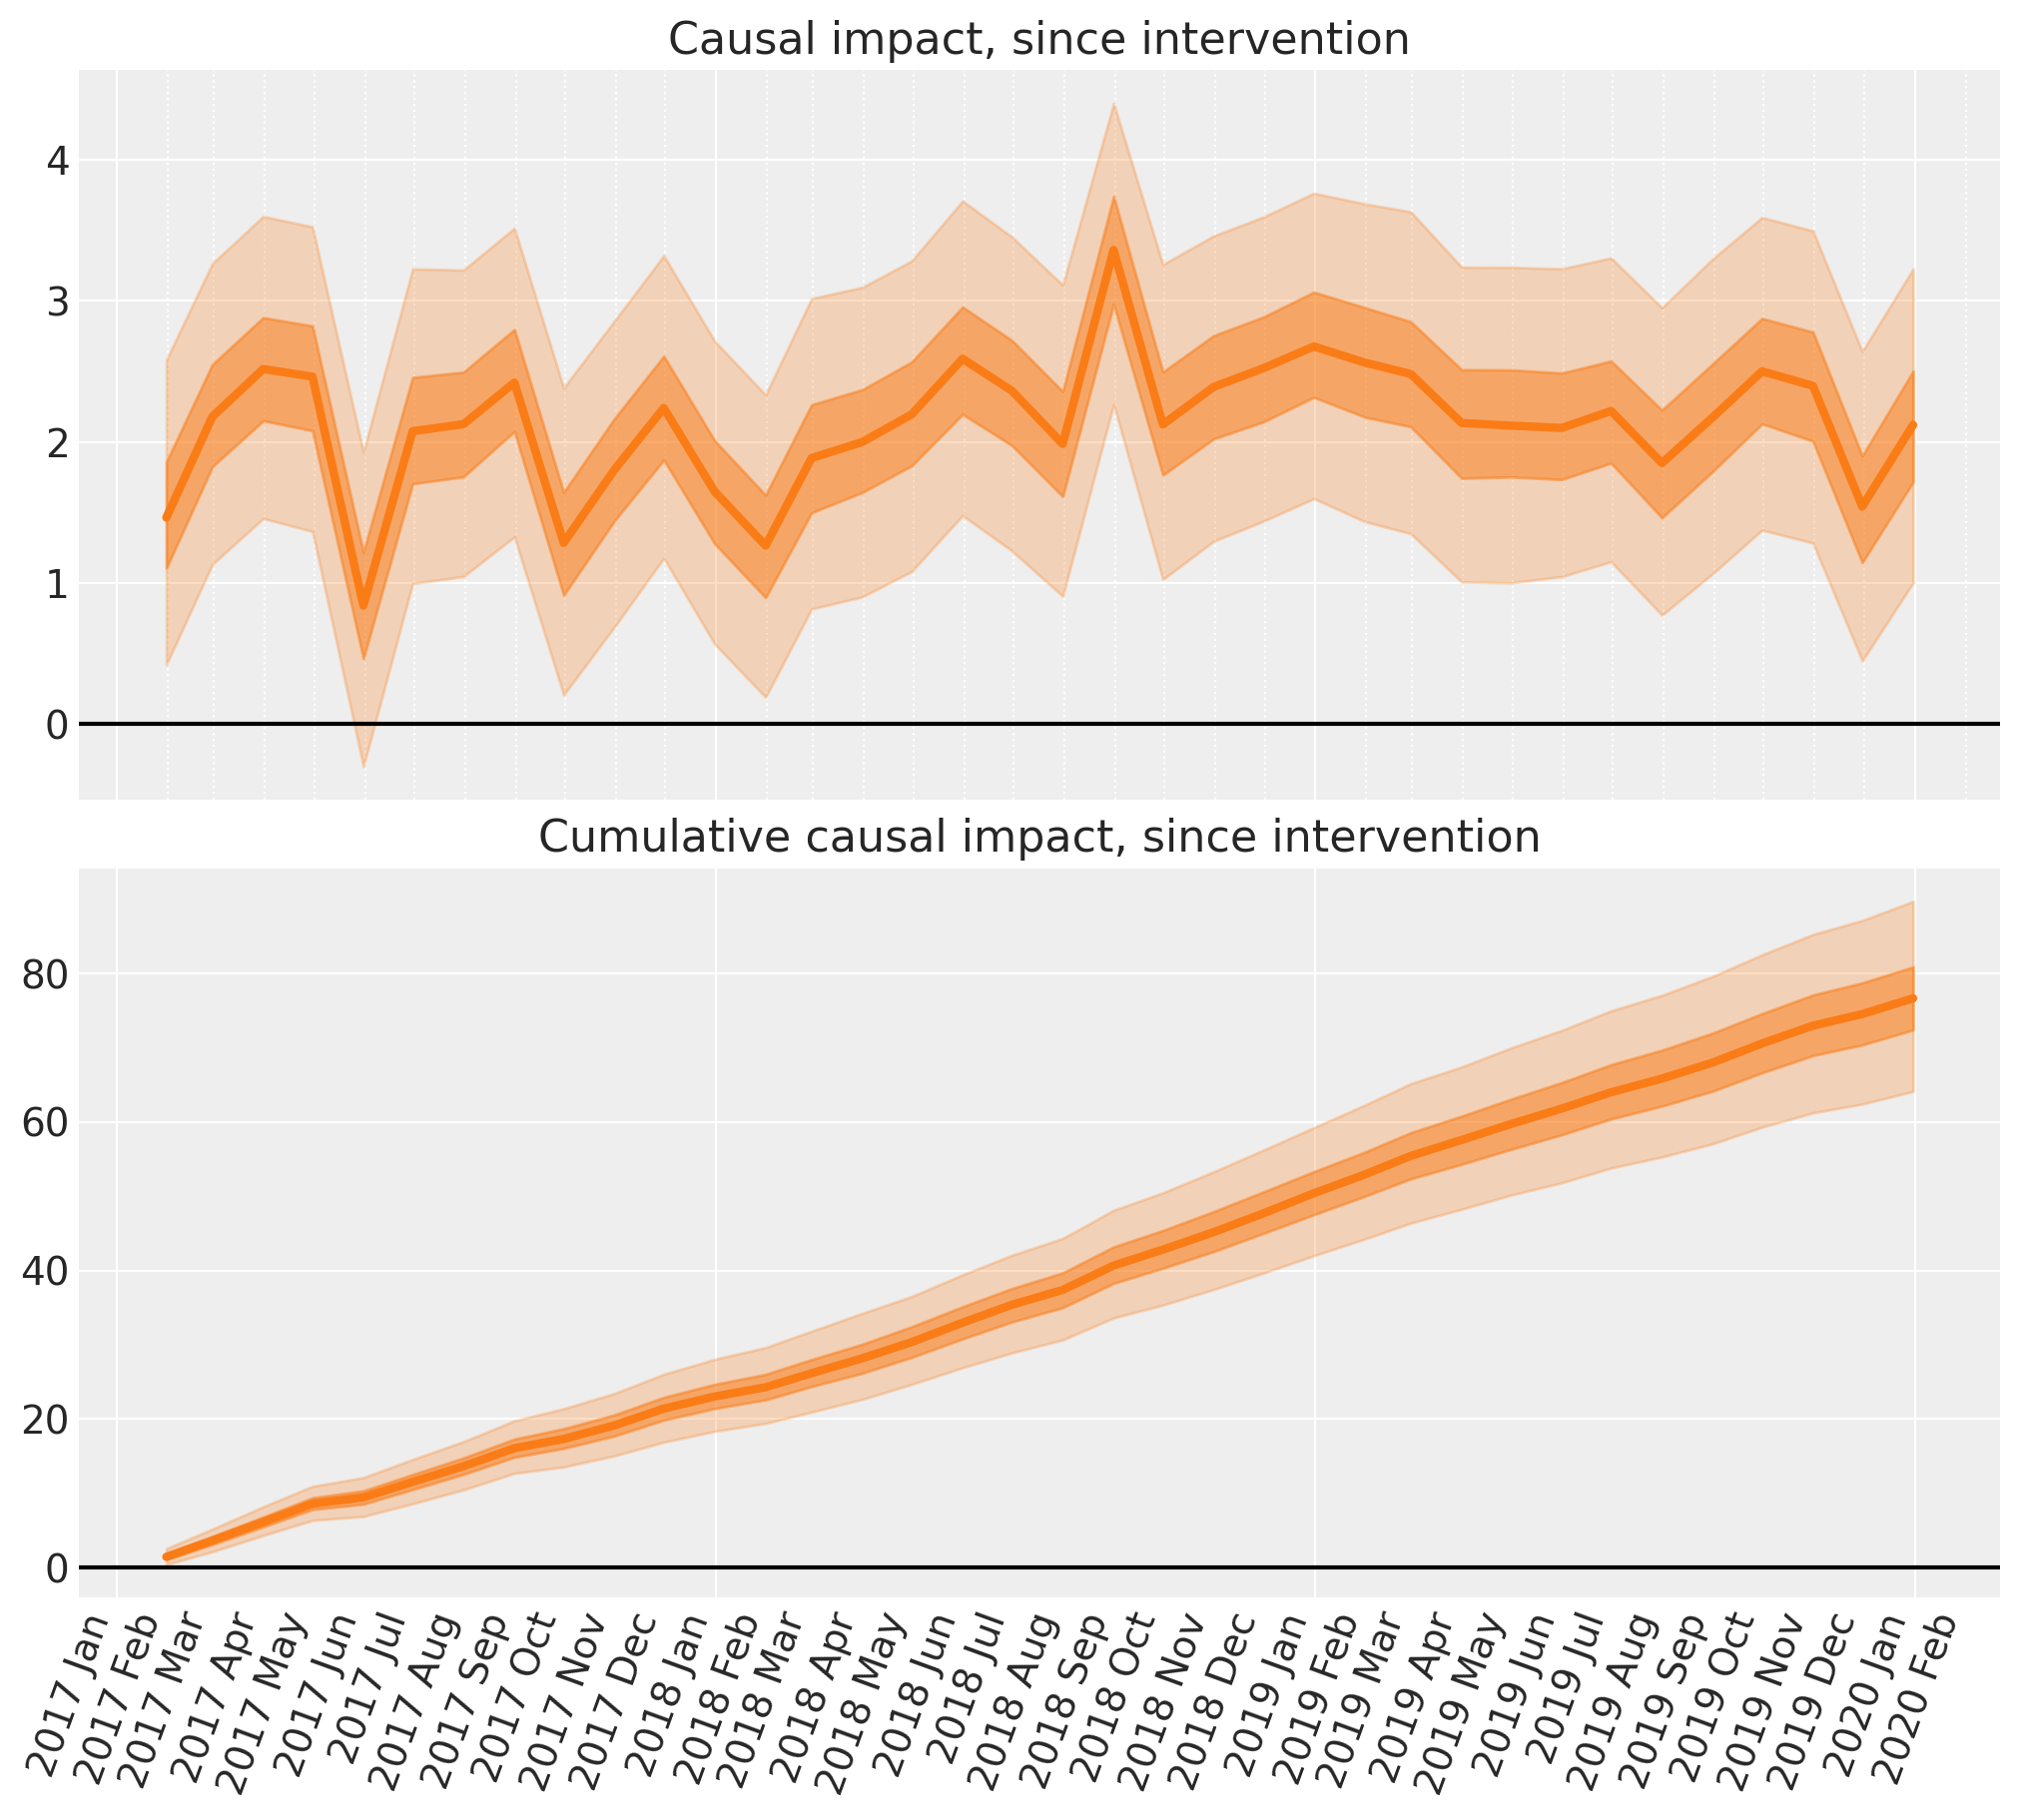

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, excess.transpose(..., "obs_id"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Causal impact, since intervention")

# Plot the cumulative excess
plot_xY(post.index, cumsum.transpose(..., "obs_id"), ax[1])
format_x_axis(ax[1], minor=False)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative causal impact, since intervention");

And there we have it - we've done some Bayesian counterfactual inference in PyMC using the interrupted time series approach! In just a few steps we've:
- Built a simple model to predict a time series.
- Inferred the model parameters based on pre intervention data, running prior and posterior predictive checks. We note that the model is pretty good.
- Used the model to create counterfactual predictions of what would happen after the intervention time if the intervention had not occurred.
- Calculated the causal impact (and cumulative causal impact) by comparing the observed outcome to our counterfactual expected outcome in the case of no intervention.

There are of course many ways that the interrupted time series approach could be more involved in real world settings. For example there could be more temporal structure, such as seasonality. If so then we might want to use a specific time series model, not just a linear regression model. There could also be additional informative predictor variables to incorporate into the model. Additionally some designs do not just consist of pre and post intervention periods (also known as A/B designs), but could also involve a period where the intervention is inactive, active, and then inactive (also known as an ABA design).

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in October 2022.

## Watermark

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Sun Oct 16 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

pytensor: 2.8.2
aeppl : 0.0.35
xarray: 2022.6.0

matplotlib: 3.6.0
pandas    : 1.5.0
numpy     : 1.23.3
xarray    : 2022.6.0
arviz     : 0.12.1
pymc      : 4.2.0

Watermark: 2.3.1



:::{include} ../page_footer.md
:::